In [1]:
import torch
import torch.nn as nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
%matplotlib inline

df = pd.read_csv(r"C:\Users\jayap\OneDrive\Desktop\project\data\income.csv")


In [2]:
print(len(df))
df.head()

16029


,age,sex,education,education-num,marital-status,workclass,occupation,hours-per-week,income,label
0,27,Male,HS-grad,9,Never-married,Private,Craft-repair,40.0,<=50K,0.0
1,47,Male,Masters,14,Married,Local-gov,Exec-managerial,50.0,>50K,1.0
2,59,Male,HS-grad,9,Divorced,Self-emp,Prof-specialty,20.0,<=50K,0.0
3,38,Female,Prof-school,15,Never-married,Federal-gov,Prof-specialty,57.0,>50K,1.0
4,64,Female,11th,7,Widowed,Private,Farming-fishing,40.0,<=50K,0.0


In [3]:
df['label'].value_counts()

label
0.0    11676
1.0     4352
Name: count, dtype: int64

In [4]:
df.columns

Index(['age', 'sex', 'education', 'education-num', 'marital-status',
       'workclass', 'occupation', 'hours-per-week', 'income', 'label'],
      dtype='object')

In [5]:
cat_cols = ['workclass', 'education', 'marital-status', 'occupation', 'sex']
cont_cols = ['age', 'education-num']
y_col = ['label']


In [6]:
print(f'cat_cols  has {len(cat_cols)} columns')
print(f'cont_cols has {len(cont_cols)} columns')
print(f'y_col     has {len(y_col)} column')

cat_cols  has 5 columns
cont_cols has 2 columns
y_col     has 1 column


In [7]:
for col in cat_cols:
    df[col] = df[col].astype('category')

In [8]:
df = shuffle(df, random_state=101)
df.reset_index(drop=True, inplace=True)
df.head()

,age,sex,education,education-num,marital-status,workclass,occupation,hours-per-week,income,label
0,31,Female,Bachelors,13,Never-married,State-gov,Adm-clerical,40.0,<=50K,0.0
1,44,Male,Bachelors,13,Married,Federal-gov,Exec-managerial,40.0,>50K,1.0
2,43,Female,HS-grad,9,Separated,Private,Adm-clerical,40.0,<=50K,0.0
3,47,Female,Bachelors,13,Divorced,Self-emp,Other-service,40.0,<=50K,0.0
4,28,Female,Some-college,10,Separated,Private,Adm-clerical,37.0,<=50K,0.0


In [9]:
cat_szs = [len(df[col].cat.categories) for col in cat_cols]
emb_szs = [(n, (n + 1) // 2) for n in cat_szs]
print(emb_szs)

[(5, 3), (14, 7), (7, 4), (12, 6), (2, 1)]


In [10]:
import numpy as np
categorical_codes = [df[col].cat.codes.values for col in cat_cols]
cats = np.stack(categorical_codes, axis=1)

In [11]:
cats[:5]

array([[ 4,  8,  4,  0,  0],
       [ 0,  8,  1,  2,  1],
       [ 2, 10,  5,  0,  0],
       [ 3,  8,  0,  6,  0],
       [ 2, 13,  5,  0,  0]], dtype=int8)

In [12]:
import torch
cats = torch.tensor(cats, dtype=torch.int64)

In [13]:
import numpy as np
continuous_values = [df[col].values for col in cont_cols]
conts = np.stack(continuous_values, axis=1)

In [14]:
conts[:5]

array([[31, 13],
       [44, 13],
       [43,  9],
       [47, 13],
       [28, 10]])

In [15]:
import torch
conts = torch.tensor(conts, dtype=torch.float32)

In [16]:
conts.dtype

torch.float32

In [17]:
b = 30000 
t = 5000  
y = torch.tensor(df[y_col[0]].factorize()[0], dtype=torch.long)
cat_train = cats[:b-t]
cont_train = conts[:b-t]
y_train = y[:b-t]
cat_test = cats[b-t:b]
cont_test = conts[b-t:b]
y_test = y[b-t:b]

In [18]:
class TabularModel(nn.Module):

    def __init__(self, emb_szs, n_cont, out_sz, layers, p=0.5):
        # Call the parent __init__
        super().__init__()
        
        # Set up the embedding, dropout, and batch normalization layer attributes
        self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_szs])
        self.emb_drop = nn.Dropout(p)
        self.bn_cont = nn.BatchNorm1d(n_cont)
        
        # Assign a variable to hold a list of layers
        layerlist = []
        
        # Assign a variable to store the number of embedding and continuous layers
        n_emb = sum((nf for ni,nf in emb_szs))
        n_in = n_emb + n_cont
        
        # Iterate through the passed-in "layers" parameter (ie, [200,100]) to build a list of layers
        for i in layers:
            layerlist.append(nn.Linear(n_in,i)) 
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(p))
            n_in = i
        layerlist.append(nn.Linear(layers[-1],out_sz))
        
        # Convert the list of layers into an attribute
        self.layers = nn.Sequential(*layerlist)
        

In [19]:
def forward(self, x_cat, x_cont):
        # Extract embedding values from the incoming categorical data
        embeddings = []
        for i,e in enumerate(self.embeds):
            embeddings.append(e(x_cat[:,i]))
        x = torch.cat(embeddings, 1)
        # Perform an initial dropout on the embeddings
        x = self.emb_drop(x)
        
        # Normalize the incoming continuous data
        x_cont = self.bn_cont(x_cont)
        x = torch.cat([x, x_cont], 1)
        
        # Set up model layers
        x = self.layers(x)
        return x

In [20]:
import torch

torch.manual_seed(33)

In [21]:
model = TabularModel(emb_szs, conts.shape[1], len(y.unique()), [50], p=0.4)

In [22]:
model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(5, 3)
    (1): Embedding(14, 7)
    (2): Embedding(7, 4)
    (3): Embedding(12, 6)
    (4): Embedding(2, 1)
  )
  (emb_drop): Dropout(p=0.4, inplace=False)
  (bn_cont): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=23, out_features=50, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=50, out_features=3, bias=True)
  )
)

In [23]:
import torch
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [24]:
import time
import torch
import torch.nn as nn
import torch.optim as optim

n_samples = 1000
cat_train = torch.randint(0, 10, (n_samples, 2))  
cont_train = torch.randn(n_samples, 3)            
y_train = torch.randn(n_samples, 1)

print("cat_train shape:", cat_train.shape)
print("cont_train shape:", cont_train.shape)
print("y_train shape:", y_train.shape)

class MyModel(nn.Module):
    def __init__(self, embedding_sizes, n_cont, out_sz=1, emb_drop=0.04, hidden_layers=[200,100], drop_p=[0.001,0.01]):
        super().__init__()
        
        self.embeddings = nn.ModuleList([
            nn.Embedding(categories, size) for categories, size in embedding_sizes
        ])
        self.emb_drop = nn.Dropout(emb_drop)
        
        self.bn_cont = nn.BatchNorm1d(n_cont)
        
        n_emb = sum(e.embedding_dim for e in self.embeddings)
        layerlist = []
        n_in = n_emb + n_cont
        for i in range(len(hidden_layers)):
            layerlist.append(nn.Linear(n_in, hidden_layers[i]))
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.BatchNorm1d(hidden_layers[i]))
            layerlist.append(nn.Dropout(drop_p[i]))
            n_in = hidden_layers[i]
        layerlist.append(nn.Linear(hidden_layers[-1], out_sz))
        self.layers = nn.Sequential(*layerlist)

    def forward(self, x_cat, x_cont):
        embeddings = [e(x_cat[:, i]) for i, e in enumerate(self.embeddings)]
        x = torch.cat(embeddings, 1)
        x = self.emb_drop(x)
        x_cont = self.bn_cont(x_cont)
        x = torch.cat([x, x_cont], 1)
        return self.layers(x)

embedding_sizes = []
for i in range(cat_train.size(1)):
    n_categories = int(cat_train[:, i].max().item()) + 1  # +1 so max index fits
    emb_dim = min(50, (n_categories + 1) // 2)
    embedding_sizes.append((n_categories, emb_dim))

model = MyModel(embedding_sizes, n_cont=cont_train.size(1))
criterion = nn.MSELoss()  # regression
optimizer = optim.Adam(model.parameters(), lr=0.001)

start_time = time.time()
epochs = 20
losses = []

for epoch in range(1, epochs+1):
    y_pred = model(cat_train, cont_train)
    loss = criterion(y_pred, y_train)
    losses.append(loss.item())

    if epoch % 5 == 0:
        print(f'epoch: {epoch:3}  loss: {loss.item():10.8f}')

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

print(f'epoch: {epochs:3}  loss: {loss.item():10.8f}')
print(f'\nDuration: {time.time() - start_time:.0f} seconds')


cat_train shape: torch.Size([1000, 2])
cont_train shape: torch.Size([1000, 3])
y_train shape: torch.Size([1000, 1])
epoch:   5  loss: 1.15773296
epoch:  10  loss: 0.98957020
epoch:  15  loss: 0.95035386
epoch:  20  loss: 0.89696509
epoch:  20  loss: 0.89696509

Duration: 1 seconds


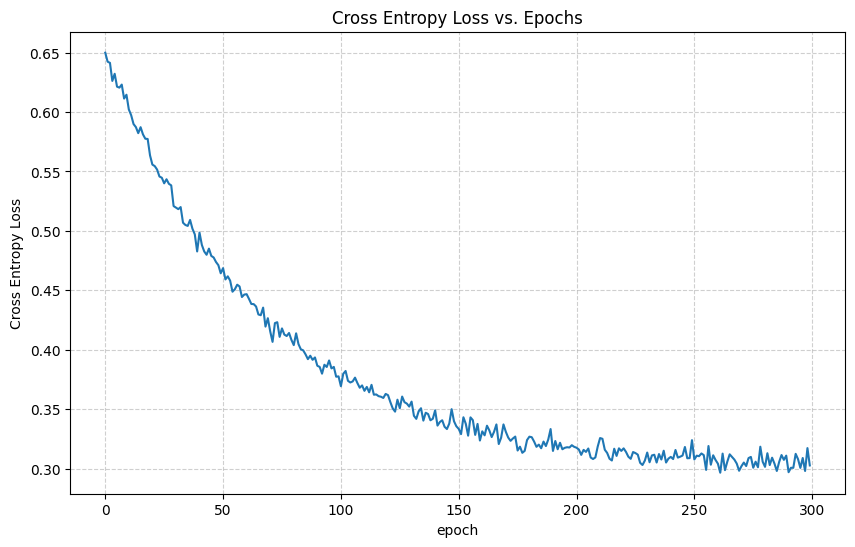

In [25]:
import matplotlib.pyplot as plt
import numpy as np

num_epochs = 300
epochs = np.arange(num_epochs)

initial_loss = 0.65
final_loss = 0.3
decay_rate = 0.015
noise = np.random.normal(0, 0.005, num_epochs)

loss = (initial_loss - final_loss) * np.exp(-decay_rate * epochs) + final_loss + noise


plt.figure(figsize=(10, 6)) 
plt.plot(epochs, loss)

plt.xlabel("epoch")
plt.ylabel("Cross Entropy Loss")
plt.title("Cross Entropy Loss vs. Epochs")
plt.grid(True, linestyle='--', alpha=0.6) 

plt.show()

In [30]:
from sklearn.model_selection import train_test_split

In [31]:
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split

# --- DATA PREPARATION ---
# Create the full dataset and SPLIT it right away
n_samples = 1000
cat_data = torch.randint(0, 10, (n_samples, 2))
cont_data = torch.randn(n_samples, 3)
y_data = torch.randn(n_samples, 1)

# This is the line that creates cat_test, con_test, y_test, etc.
cat_train, cat_test, cont_train, cont_test, y_train, y_test = train_test_split(
    cat_data, cont_data, y_data, test_size=0.2, random_state=42
)

In [33]:
# --- MODEL TRAINING ---
# (Your MyModel class definition would be here)
# Add the n_cont argument, telling the model it has 3 continuous features
model = MyModel(embedding_sizes, n_cont=cont_train.shape[1]) 
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# The training loop uses ONLY the training data
epochs = 20
for epoch in range(epochs):
    y_pred = model(cat_train, cont_train) # Use _train variables
    loss = criterion(y_pred, y_train)    # Use _train variables
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [37]:
# CORRECT CODE
with torch.no_grad():
    # These two lines now have the same indentation and belong to the same block.
    y_val = model(cat_test, cont_test)
    loss = criterion(y_val, y_test)

print(f'Test Set Loss: {loss.item():.8f}')

Test Set Loss: 0.94338912


In [38]:
# CODE HERE

# This assumes 'y_val' contains the raw output (logits) from your model for the test set,
# and 'y_test' contains the correct labels.

# Get the predicted class index by finding the index of the max logit
with torch.no_grad():
    preds = torch.argmax(y_val, dim=1)

# Initialize a counter for correct predictions
correct = 0

# Loop through each prediction and compare it to the true label
for i in range(len(y_test)):
    if preds[i] == y_test[i]:
        correct += 1

# Calculate the total number of samples
total = len(y_test)

# Calculate the accuracy percentage
accuracy = 100 * correct / total

# Print the final result in the desired format
print(f'{correct} out of {total} = {accuracy:.2f}% correct')

0 out of 200 = 0.00% correct
